In [1]:
import numpy as np
import pandas as pd
import pandas_profiling as pd_p
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing as pre
from sklearn.pipeline import Pipeline as pipe
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
import random
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('OJ.csv')
data = data.drop(columns='Id')
data['Purchase'] = data['Purchase'].replace(['CH','MM'],[1,0])
data['Store7'] = data['Store7'].replace(['Yes','No'],[1,0])
data = data.drop('STORE',axis = 1)
data_dummy = pd.get_dummies(data)

In [3]:
def setup(data, target, split=0.7):
  from sklearn.model_selection import train_test_split
  X = data.drop(target,axis=1)
  y = data[target]
  global X_train, X_test, y_train, y_test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
  #simple_logistic_model = LogisticRegression(solver='lbfgs', max_iter=10000)

In [4]:
setup(data_dummy, 'Purchase')

In [33]:
def base_model(data_X=X_train, data_y=y_train, estimator=None, ensemble = False, method = 'Bagging', 
               fold=10, round=4, plot=None):
    
  from sklearn.linear_model import LogisticRegression
  from sklearn.neighbors import KNeighborsClassifier
  from sklearn.naive_bayes import GaussianNB
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.svm import SVC
  from sklearn.gaussian_process.kernels import RBF
  from sklearn.gaussian_process import GaussianProcessClassifier
  from sklearn.neural_network import MLPClassifier
  from sklearn.model_selection import StratifiedKFold  
  from sklearn.model_selection import StratifiedKFold
  from sklearn.linear_model import RidgeClassifier
  import numpy as np
  import pandas as pd
  import pandas_profiling as pd_p
  import seaborn as sns
  from sklearn import preprocessing as pre
  from sklearn.pipeline import Pipeline as pipe
  from sklearn.model_selection import train_test_split
  #from sklearn.linear_model import RidgeClassifier
  from sklearn.linear_model import Lasso
  from sklearn.linear_model import LogisticRegression
  from sklearn.linear_model import SGDClassifier
  from sklearn import metrics
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.model_selection import GridSearchCV
  from sklearn.model_selection import RandomizedSearchCV
  from scipy import stats
  import random
  from sklearn.model_selection import cross_val_score
  from sklearn.model_selection import cross_val_predict
  from sklearn.model_selection import cross_validate
  from sklearn.ensemble import AdaBoostClassifier
  from sklearn.ensemble import GradientBoostingClassifier
  from sklearn.model_selection import StratifiedKFold
  from sklearn.metrics import roc_auc_score
  from sklearn.metrics import cohen_kappa_score
  from sklearn.ensemble import BaggingClassifier
  from yellowbrick.classifier import roc_auc
  from yellowbrick.classifier import ROCAUC
  from yellowbrick.classifier import discrimination_threshold
  from yellowbrick.classifier import precision_recall_curve
  from yellowbrick.classifier import confusion_matrix
  from yellowbrick.classifier import class_prediction_error
  from yellowbrick.classifier import classification_report
    
  kf = StratifiedKFold(fold)

  score_auc =np.empty((0,0))
  score_acc =np.empty((0,0))
  score_recall =np.empty((0,0))
  score_precision =np.empty((0,0))
  score_f1 =np.empty((0,0))
  score_kappa =np.empty((0,0))
  avgs_auc =np.empty((0,0))
  avgs_acc =np.empty((0,0))
  avgs_recall =np.empty((0,0))
  avgs_precision =np.empty((0,0))
  avgs_f1 =np.empty((0,0))
  avgs_kappa =np.empty((0,0))
  
  global model, full_name
    
  #if estimator == 'lr':
    #model = LogisticRegression(solver='lbfgs',max_iter=10000)
  if estimator == 'knn':
    model = KNeighborsClassifier()
    full_name = 'K Nearest Neighbours'
  elif estimator == 'nb':
    model = GaussianNB()
    full_name = 'Naive Bayes'
  elif estimator == 'dt':
    model = DecisionTreeClassifier()
    full_name = 'Decision Tree'
  elif estimator == 'svm':
    model = SVC(probability=True,kernel='linear')
    full_name = 'Support Vector Machine'
  elif estimator == 'rbfsvm':
    model = SVC(gamma='auto', C=1, probability=True, kernel='rbf')
    full_name = 'RBF SVM'
  elif estimator == 'gpc':
    model = GaussianProcessClassifier()
    full_name = 'Gaussian Process Classifier'
  elif estimator == 'mlp':
    model = MLPClassifier(max_iter=500)
    full_name = 'Multi Level Perceptron'
  #elif estimator == 'ridge':
    #model = RidgeClassifier()
  else:
    model = LogisticRegression(solver='lbfgs',max_iter=10000)
    full_name = "Logistic Regression"
  #pass
    
  #checking ensemble method
    
  if ensemble and method == 'Bagging':
    model = BaggingClassifier(model,bootstrap=True,n_estimators=10)
  elif ensemble and method == 'Boosting':
    model = AdaBoostClassifier(model)
  elif method == 'Boosting':
    model = AdaBoostClassifier(model)
  #else:
    #model = model
    
  for train_i , test_i in kf.split(data_X,data_y):
  #print("TRAIN:", train_i, "TEST:", test_i)
    
    Xtrain,Xtest = data_X.iloc[train_i], data_X.iloc[test_i]
    ytrain,ytest = data_y.iloc[train_i], data_y.iloc[test_i]
    
    model.fit(Xtrain,ytrain)
    pred_prob = model.predict_proba(Xtest)
    pred_prob = pred_prob[:,1]
    pred_ = model.predict(Xtest)
    sca = metrics.accuracy_score(ytest,pred_)
    sc = metrics.roc_auc_score(ytest,pred_prob)
    recall = metrics.recall_score(ytest,pred_)
    precision = metrics.average_precision_score(ytest,pred_prob)
    kappa = cohen_kappa_score(ytest,pred_)
    f1 = metrics.f1_score(ytest,pred_)
    score_acc = np.append(score_acc,sca)
    score_auc = np.append(score_auc,sc)
    score_recall = np.append(score_recall,recall)
    score_precision = np.append(score_precision,precision)
    score_f1 =np.append(score_f1,f1)
    score_kappa =np.append(score_kappa,kappa)
     
  mean_acc=np.mean(score_acc)
  mean_auc=np.mean(score_auc)
  mean_recall=np.mean(score_recall)
  mean_precision=np.mean(score_precision)
  mean_f1=np.mean(score_f1)
  mean_kappa=np.mean(score_kappa)
  std_acc=np.std(score_acc)
  std_auc=np.std(score_auc)
  std_recall=np.std(score_recall)
  std_precision=np.std(score_precision)
  std_f1=np.std(score_f1)
  std_kappa=np.std(score_kappa)
    
  avgs_acc = np.append(avgs_acc, mean_acc)
  avgs_acc = np.append(avgs_acc, std_acc) 
  avgs_auc = np.append(avgs_auc, mean_auc)
  avgs_auc = np.append(avgs_auc, std_auc)
  avgs_recall = np.append(avgs_recall, mean_recall)
  avgs_recall = np.append(avgs_recall, std_recall)
  avgs_precision = np.append(avgs_precision, mean_precision)
  avgs_precision = np.append(avgs_precision, std_precision)
  avgs_f1 = np.append(avgs_f1, mean_f1)
  avgs_f1 = np.append(avgs_f1, std_f1)
  avgs_kappa = np.append(avgs_kappa, mean_kappa)
  avgs_kappa = np.append(avgs_kappa, std_kappa)
  
  global base_model_, base_model_unpivot_
      
  base_model_ = pd.DataFrame({'Accuracy': score_acc, 'AUC': score_auc, 'Recall' : score_recall, 'Prec.' : score_precision , 
                     'F1' : score_f1, 'Kappa' : score_kappa})
  base_model_unpivot_ = pd.melt(base_model_,value_vars=['Accuracy', 'AUC', 'Recall', 'Prec.', 'F1', 'Kappa'])
  base_model_unpivot_.columns = ['Metric', 'Measure']
  base_model_avgs = pd.DataFrame({'Accuracy': avgs_acc, 'AUC': avgs_auc, 'Recall' : avgs_recall, 'Prec.' : avgs_precision , 
                     'F1' : avgs_f1, 'Kappa' : avgs_kappa},index=['Mean', 'SD'])
  
  base_model_ = base_model_.append(base_model_avgs)
  base_model_ = base_model_.round(round)  
  #return base_model_
  #global base_model_auc
  #base_model_auc = roc_auc(model, X_train, y_train)
  
  if plot == 'None':
    from IPython.display import display, HTML
    display(HTML(base_model_.to_html()))
    
  elif plot == 'auc':
    from yellowbrick.classifier import ROCAUC
    visualizer = ROCAUC(model)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.poof()
    
  elif plot == 'threshold':
    #visualizer = discrimination_threshold(model, X_train, y_train)
    from yellowbrick.classifier import DiscriminationThreshold
    visualizer = DiscriminationThreshold(model)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.poof()
    
  elif plot == 'pr':
    #visualizer = precision_recall_curve(model, X_train, y_train)
    from yellowbrick.classifier import PrecisionRecallCurve
    visualizer = PrecisionRecallCurve(model)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.poof()
    
  elif plot == 'confusion_matrix':
    #visualizer = confusion_matrix(model, X_train, y_train, cmap="Greens", fontsize=25)
    from yellowbrick.classifier import ConfusionMatrix
    visualizer = ConfusionMatrix(model, fontsize=20, cmap="Greens")
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.poof()
    
  elif plot == 'error':
    #visualizer = class_prediction_error(model, X_train, y_train)
    from yellowbrick.classifier import ClassPredictionError
    visualizer = ClassPredictionError(model)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.poof()
        
  elif plot == 'class_report':
    #visualizer = classification_report(model, X_train, y_train)
    from yellowbrick.classifier import ClassificationReport
    visualizer = ClassificationReport(model, support=True)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.poof()

  #elif plot == 'tree':
    
    #from sklearn import tree
    #from sklearn.tree import plot_tree
    #from sklearn.tree import DecisionTreeClassifier, plot_tree
    #model = tree.DecisionTreeClassifier()
    #model = model.fit(X_train, y_train)
    #plot_tree(model.fit(X_train, y_train))
    
  elif plot == 'boundary':
        
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from yellowbrick.contrib.classifier import DecisionViz        
    
    #global X_train, X_test, y_train, y_test
    X_train_transformed = X_train.select_dtypes(include='float64')
    X_test_transformed = X_test.select_dtypes(include='float64')
    X_train_transformed = StandardScaler().fit_transform(X_train_transformed)
    X_test_transformed = StandardScaler().fit_transform(X_test_transformed)
    pca = PCA(n_components=2)
    X_train_transformed = pca.fit_transform(X_train_transformed)
    X_test_transformed = pca.fit_transform(X_test_transformed)

    y_train_transformed = np.array(y_train)
    y_test_transformed = np.array(y_test)

    viz = DecisionViz(model)
    viz.fit(X_train_transformed, y_train_transformed, features=['Feature One', 'Feature Two'], classes=['A', 'B'])
    viz.draw(X_test_transformed, y_test_transformed)
    viz.poof()    
    
  elif plot == 'learning':
    from yellowbrick.model_selection import LearningCurve
    cv = fold
    sizes = np.linspace(0.3, 1.0, 10)  
    visualizer = LearningCurve(model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4)
    visualizer.fit(X_train, y_train)
    visualizer.poof()
    
  elif plot == 'rfe':
    from yellowbrick.model_selection import RFECV    
    visualizer = RFECV(model, cv=fold)
    visualizer.fit(X_train, y_train)
    visualizer.poof()

  elif plot == 'manifold':
    from yellowbrick.features import Manifold
    X_train_transformed = X_train.select_dtypes(include='float64') 
    visualizer = Manifold(manifold="tsne")
    visualizer.fit_transform(X_train_transformed, y_train)
    visualizer.poof()
    
  elif plot == 'vc':
    
    if estimator == 'dt':
       
        from yellowbrick.model_selection import ValidationCurve
        viz = ValidationCurve(model, param_name="max_depth", param_range=np.arange(1,11), scoring='f1_weighted',cv=fold)
        viz.fit(X_train, y_train)
        viz.poof()
        
    elif estimator == 'svm':
        pass
    
        #from yellowbrick.model_selection import ValidationCurve
        #viz = ValidationCurve(model, param_name="C", param_range=np.arange(1,5), scoring='f1_weighted',cv=fold)
        #viz.fit(X_train, y_train)
        #viz.poof()

  elif plot == 'dimension':
    
    from yellowbrick.features import RadViz
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    
    X_train_transformed = X_train.select_dtypes(include='float64') 
    X_train_transformed = StandardScaler().fit_transform(X_train_transformed)
    y_train_transformed = np.array(y_train)
    
    pca = PCA(n_components=5)
    X_train_transformed = pca.fit_transform(X_train_transformed)
    
    classes = ["1", "0"]
    visualizer = RadViz(classes=classes)
    visualizer.fit(X_train_transformed, y_train_transformed)           # Fit the data to the visualizer
    visualizer.transform(X_train_transformed)        # Transform the data
    visualizer.poof()              # Draw/show/poof the data
        
  elif plot == 'calibration':
    
    from sklearn.calibration import calibration_curve
    
    plt.figure(figsize=(7, 6))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    model.fit(X_train, y_train)
    prob_pos = model.predict_proba(X_test)[:, 1]
    prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",label="%s" % (full_name, ))

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([0, 1])
    ax1.set_xlim([0, 1])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')
    ax1.set_facecolor('white')
    ax1.grid(b=True, color='grey', linewidth=0.5, linestyle = '-')
    plt.tight_layout()
    plt.show()   
        
  elif plot == 'feature':
    #visualizer = confusion_matrix(model, X_train, y_train, cmap="Greens", fontsize=25)        
    #from IPython.display import display, HTML
    #display(HTML(base_model_.to_html()))
    variables = abs(model.coef_[0])
    col_names = np.array(X_train.columns)
    coef_df = pd.DataFrame({'Variable': X_train.columns, 'Value': variables})
    sorted_df = coef_df.sort_values(by='Value')
    my_range=range(1,len(sorted_df.index)+1)
    plt.figure(figsize=(8,5))
    plt.hlines(y=my_range, xmin=0, xmax=sorted_df['Value'], color='skyblue')
    plt.plot(sorted_df['Value'], my_range, "o")
    plt.yticks(my_range, sorted_df['Variable'])
    plt.title("Feature Importance Plot")
    plt.xlabel('Variable Importance')
    plt.ylabel('Features') 
    global var_imp_array_top_n
    var_imp = sorted_df.reset_index(drop=True)
    var_imp_array = np.array(var_imp['Variable'])
    var_imp_array_top_n = var_imp_array[0:len(var_imp_array)]

  elif plot == 'cv':
    sns.set(rc={'figure.figsize':(8,5)})
    sns.boxplot(x='Metric', y='Measure', data=base_model_unpivot_, width=0.5, linewidth=1, palette='Set2').set_title('Results from K-Fold Cross Validation')
    
  else:
    from IPython.display import display, HTML
    display(HTML(base_model_.to_html()))
    #global base_model_plot

In [6]:
def optimize_model(data_X=X_train, n=3):
    global X_train
    drop_list = var_imp_array_top_n[0:n]
    X_train.drop(drop_list, axis=1, inplace=True)
    #X_test.drop(drop_list, axis=1)

In [7]:
#compare_models() function

def compare_models(data_X=X_train, data_y=y_train, fold=10, round=4, sort='Accuracy', plot=False, ensemble=False, 
                   method='Bagging'):

  from sklearn.linear_model import LogisticRegression
  from sklearn.neighbors import KNeighborsClassifier
  from sklearn.naive_bayes import GaussianNB
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.svm import SVC
  from sklearn.gaussian_process.kernels import RBF
  from sklearn.gaussian_process import GaussianProcessClassifier
  from sklearn.neural_network import MLPClassifier
  from sklearn.model_selection import StratifiedKFold
  from sklearn import preprocessing as pre
  from sklearn.pipeline import Pipeline as pipe
  from sklearn.model_selection import train_test_split
  from sklearn.linear_model import RidgeClassifier
  from sklearn.linear_model import Lasso
  from sklearn.linear_model import LogisticRegression
  from sklearn.linear_model import SGDClassifier
  from sklearn import metrics
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.model_selection import GridSearchCV
  from sklearn.model_selection import RandomizedSearchCV
  from scipy import stats
  from sklearn.model_selection import cross_val_score
  from sklearn.model_selection import cross_val_predict
  from sklearn.model_selection import cross_validate
  from sklearn.ensemble import AdaBoostClassifier
  from sklearn.ensemble import GradientBoostingClassifier
  from sklearn.ensemble import BaggingClassifier
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.model_selection import StratifiedKFold
  from sklearn.metrics import roc_auc_score
  from sklearn.metrics import cohen_kappa_score
  import numpy as np
  import pandas as pd
  import pandas_profiling as pd_p
  import seaborn as sns
  import random
  import pandas.io.formats.style

  lr = LogisticRegression(solver='lbfgs',max_iter=10000)
  knn = KNeighborsClassifier()
  nb = GaussianNB()
  dt = DecisionTreeClassifier()
  svm = SVC(probability=True,kernel='linear')
  rbfsvm = SVC(gamma='auto', C=1, probability=True, kernel='rbf')
  gpc = GaussianProcessClassifier()
  mlp = MLPClassifier(max_iter=500)

  if ensemble and method == 'Bagging':
    lr = BaggingClassifier(lr,bootstrap=True,n_estimators=10)    
    knn = BaggingClassifier(knn,bootstrap=True,n_estimators=10)
    nb = BaggingClassifier(nb,bootstrap=True,n_estimators=10)
    dt = RandomForestClassifier()
    svm = BaggingClassifier(svm,bootstrap=True,n_estimators=10)
    rbfsvm = BaggingClassifier(rbfsvm,bootstrap=True,n_estimators=10)
    gpc = BaggingClassifier(gpc,bootstrap=True,n_estimators=10)
    mlp = BaggingClassifier(mlp,bootstrap=True,n_estimators=10)
     
  elif ensemble and method == 'Boosting':
    lr = AdaBoostClassifier(lr)
    knn = knn
    nb = AdaBoostClassifier(nb)
    dt = GradientBoostingClassifier()
    svm = AdaBoostClassifier(svm)
    rbfsvm = AdaBoostClassifier(rbfsvm)
    gpc = gpc
    mlp = mlp
  
  else:
    lr = LogisticRegression(solver='lbfgs',max_iter=10000)
    knn = KNeighborsClassifier()
    nb = GaussianNB()
    dt = DecisionTreeClassifier()
    svm = SVC(probability=True,kernel='linear')
    rbfsvm = SVC(gamma='auto', C=1, probability=True, kernel='rbf')
    gpc = GaussianProcessClassifier()
    mlp = MLPClassifier(max_iter=500)

  model_library = list([lr, knn, nb, dt, svm, rbfsvm, gpc, mlp])

  kf = StratifiedKFold(fold)

  score_acc =np.empty((0,0))
  score_auc =np.empty((0,0))
  score_recall =np.empty((0,0))
  score_precision =np.empty((0,0))
  score_f1 =np.empty((0,0))
  score_kappa =np.empty((0,0))
  global score_acc_running
  score_acc_running = np.empty((0,0)) ##running total
  avg_acc = np.empty((0,0))
  avg_auc = np.empty((0,0))
  avg_recall = np.empty((0,0))
  avg_precision = np.empty((0,0))
  avg_f1 = np.empty((0,0))
  avg_kappa = np.empty((0,0))
      
  for model in model_library:
    
    for train_i , test_i in kf.split(data_X,data_y):
     
        Xtrain,Xtest = data_X.iloc[train_i], data_X.iloc[test_i]
        ytrain,ytest = data_y.iloc[train_i], data_y.iloc[test_i]
        model.fit(Xtrain,ytrain)
        pred_prob = model.predict_proba(Xtest)
        pred_prob = pred_prob[:,1]
        pred_ = model.predict(Xtest)
        sca = metrics.accuracy_score(ytest,pred_)
        sc = metrics.roc_auc_score(ytest,pred_prob)
        recall = metrics.recall_score(ytest,pred_)
        precision = metrics.average_precision_score(ytest,pred_prob)
        kappa = cohen_kappa_score(ytest,pred_)
        f1 = metrics.f1_score(ytest,pred_)
        score_acc = np.append(score_acc,sca)
        score_auc = np.append(score_auc,sc)
        score_recall = np.append(score_recall,recall)
        score_precision = np.append(score_precision,precision)
        score_f1 =np.append(score_f1,f1)
        score_kappa =np.append(score_kappa,kappa)
        score_acc_running = np.append(score_acc_running,sca)
    avg_acc = np.append(avg_acc,np.mean(score_acc))
    avg_auc = np.append(avg_auc,np.mean(score_auc))
    avg_recall = np.append(avg_recall,np.mean(score_recall))
    avg_precision = np.append(avg_precision,np.mean(score_precision))
    avg_f1 = np.append(avg_f1,np.mean(score_f1))
    avg_kappa = np.append(avg_kappa,np.mean(score_kappa))
    score_acc =np.empty((0,0))
    score_auc =np.empty((0,0))
    score_recall =np.empty((0,0))
    score_precision =np.empty((0,0))
    score_f1 =np.empty((0,0))
    score_kappa =np.empty((0,0))
  
  model_list = ['Logistic Regression', 'K Nearest Neighbours', 'Gaussian Naive Bayes',
                           'Decision Tree', 'Support Vector Machine - Linear', 'Support Vector Machine - RBF',
                           'Gaussian Process Classifier', 'Neural Net - Multi Level Perceptron']
  
  model_list_short = ['LR', 'KNN', 'NB', 'DT', 'SVM-L', 'SVM-RBF','GPC', 'NN-MLP']    
  model_list_repeat = np.repeat(model_list_short, fold)

  compare_models_unpivot = pd.DataFrame({'Model': model_list_repeat, 'Accuracy':score_acc_running}) #accuracy hardcoded
  
  global compare_models_
  
  def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

  compare_models_ = pd.DataFrame({'Model':model_list, 'Accuracy':avg_acc, 'AUC':avg_auc, 
                     'Recall':avg_recall, 'Prec.':avg_precision, 
                     'F1':avg_f1, 'Kappa': avg_kappa}).round(round).sort_values(by=[sort], 
                      ascending=False).reset_index(drop=True).style.apply(highlight_max,subset=['Accuracy','AUC','Recall',
                      'Prec.','F1','Kappa'])
  compare_models_ = compare_models_.set_properties(**{'text-align': 'left'})
  compare_models_ = compare_models_.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
                  
  if plot:
    display(compare_models_)
    sns.set(rc={'figure.figsize':(8.7,5.7)})
    sns.boxplot(x='Model', y='Accuracy', data=compare_models_unpivot, width=0.5, linewidth=1, palette='Set2').set_title('Models Accuracy Comparison on Cross Validation') 
    #accuracy hardcdoded
  else:  
    return compare_models_

In [8]:
def tune_model():
    pass

In [9]:
def blend_models(data_X=X_train, data_y=y_train, fold=10, round=4, sort='Accuracy'):
  
  from sklearn.linear_model import LogisticRegression
  from sklearn.neighbors import KNeighborsClassifier
  from sklearn.naive_bayes import GaussianNB
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.svm import SVC
  from sklearn.gaussian_process.kernels import RBF
  from sklearn.gaussian_process import GaussianProcessClassifier
  from sklearn.neural_network import MLPClassifier
  from sklearn.model_selection import StratifiedKFold
  import numpy as np
  import pandas as pd
  import pandas_profiling as pd_p
  import seaborn as sns
  from sklearn import preprocessing as pre
  from sklearn.pipeline import Pipeline as pipe
  from sklearn.model_selection import train_test_split
  from sklearn.linear_model import RidgeClassifier
  from sklearn.linear_model import Lasso
  from sklearn.linear_model import LogisticRegression
  from sklearn.linear_model import SGDClassifier
  from sklearn import metrics
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.model_selection import GridSearchCV
  from sklearn.model_selection import RandomizedSearchCV
  from scipy import stats
  import random
  from sklearn.model_selection import cross_val_score
  from sklearn.model_selection import cross_val_predict
  from sklearn.model_selection import cross_validate
  from sklearn.ensemble import AdaBoostClassifier
  from sklearn.ensemble import GradientBoostingClassifier
  from sklearn.model_selection import StratifiedKFold
  from sklearn.metrics import roc_auc_score
  from sklearn.metrics import cohen_kappa_score
  from sklearn.ensemble import BaggingClassifier
  from sklearn.ensemble import VotingClassifier

  kf = StratifiedKFold(fold)

  score_auc =np.empty((0,0))
  score_acc =np.empty((0,0))
  score_recall =np.empty((0,0))
  score_precision =np.empty((0,0))
  score_f1 =np.empty((0,0))
  score_kappa =np.empty((0,0))
  #avgs_auc =np.empty((0,0))
  #avgs_acc =np.empty((0,0))
  #avgs_recall =np.empty((0,0))
  #avgs_precision =np.empty((0,0))
  #avgs_f1 =np.empty((0,0))
  #avgs_kappa =np.empty((0,0))
  avg_acc = np.empty((0,0))
  avg_auc = np.empty((0,0))
  avg_recall = np.empty((0,0))
  avg_precision = np.empty((0,0))
  avg_f1 = np.empty((0,0))
  avg_kappa = np.empty((0,0))
  
  lr = LogisticRegression(solver='lbfgs',max_iter=10000)
  knn = KNeighborsClassifier()
  nb = GaussianNB()
  dt = DecisionTreeClassifier()
  svm = SVC(probability=True,kernel='linear')
  rbfsvm = SVC(gamma='auto', C=1, probability=True, kernel='rbf')
  gpc = GaussianProcessClassifier()
  mlp = MLPClassifier(max_iter=500)
  
  #comb = [('lr',lr),('knn', knn),('nb', nb)]
  comb = [[('lr',lr),('knn', knn),('nb', nb), ('dt', dt), ('svm', svm), ('rbfsvm', rbfsvm), ('gpc', gpc)],
          [('lr',lr),('knn', knn),('nb', nb), ('dt', dt), ('svm', svm), ('rbfsvm', rbfsvm), ('mlp', mlp)],
          [('lr',lr),('knn', knn),('nb', nb), ('dt', dt), ('svm', svm), ('gpc', gpc), ('mlp', mlp)],
          [('lr',lr),('knn', knn),('nb', nb), ('dt', dt), ('rbfsvm', rbfsvm), ('gpc', gpc), ('mlp', mlp)],
          [('lr',lr),('knn', knn),('nb', nb), ('svm', svm), ('rbfsvm', rbfsvm), ('gpc', gpc), ('mlp', mlp)],
          [('lr',lr),('knn', knn),('dt', dt), ('svm', svm), ('rbfsvm', rbfsvm), ('gpc', gpc), ('mlp', mlp)],
          [('lr',lr),('nb', nb),('dt', dt), ('svm', svm), ('rbfsvm', rbfsvm), ('gpc', gpc), ('mlp', mlp)],
          [('knn',knn),('nb', nb),('dt', dt), ('svm', svm), ('rbfsvm', rbfsvm), ('gpc', gpc), ('mlp', mlp)]]
    
  for i in comb:
    model = VotingClassifier(estimators=i, voting='soft', n_jobs=-1)
  
    for train_i , test_i in kf.split(data_X,data_y):
        
        Xtrain,Xtest = data_X.iloc[train_i], data_X.iloc[test_i]
        ytrain,ytest = data_y.iloc[train_i], data_y.iloc[test_i]
        model.fit(Xtrain,ytrain)
        pred_prob = model.predict_proba(Xtest)
        pred_prob = pred_prob[:,1]
        pred_ = model.predict(Xtest)
        sca = metrics.accuracy_score(ytest,pred_)
        sc = metrics.roc_auc_score(ytest,pred_prob)
        recall = metrics.recall_score(ytest,pred_)
        precision = metrics.average_precision_score(ytest,pred_prob)
        kappa = cohen_kappa_score(ytest,pred_)
        f1 = metrics.f1_score(ytest,pred_)
        score_acc = np.append(score_acc,sca)
        score_auc = np.append(score_auc,sc)
        score_recall = np.append(score_recall,recall)
        score_precision = np.append(score_precision,precision)
        score_f1 =np.append(score_f1,f1)
        score_kappa =np.append(score_kappa,kappa)
        #score_acc_running = np.append(score_acc_running,sca)
    avg_acc = np.append(avg_acc,np.mean(score_acc))
    avg_auc = np.append(avg_auc,np.mean(score_auc))
    avg_recall = np.append(avg_recall,np.mean(score_recall))
    avg_precision = np.append(avg_precision,np.mean(score_precision))
    avg_f1 = np.append(avg_f1,np.mean(score_f1))
    avg_kappa = np.append(avg_kappa,np.mean(score_kappa))
    score_acc =np.empty((0,0))
    score_auc =np.empty((0,0))
    score_recall =np.empty((0,0))
    score_precision =np.empty((0,0))
    score_f1 =np.empty((0,0))
    score_kappa =np.empty((0,0))
  
  model_list = ['LR + KNN + NB + DT + SVM + SVM-RBF + GPC', 
                'LR + KNN + NB + DT + SVM + SVM-RBF + MLP', 
                'LR + KNN + NB + DT + SVM + GPC + MLP',
                'LR + KNN + NB + DT + SVM-RBF + GPC + MLP',
                'LR + KNN + NB + SVM + SVM-RBF + GPC + MLP',
                'LR + KNN + DT + SVM + SVM-RBF + GPC + MLP',                
                'LR + NB + DT + SVM + SVM-RBF + GPC + MLP',                
                'KNN + NB + DT + SVM + SVM-RBF + GPC + MLP']
                      
  #model_list_short = ['LR', 'KNN', 'NB', 'DT', 'SVM-L', 'SVM-RBF','GPC', 'NN-MLP']    
  #model_list_repeat = np.repeat(model_list_short, fold)

  #compare_models_unpivot = pd.DataFrame({'Model': model_list_repeat, 'Accuracy':score_acc_running}) #accuracy hardcoded
  
  global blend_models_
  
  def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

  blend_models_ = pd.DataFrame({'Model':model_list, 'Accuracy':avg_acc, 'AUC':avg_auc, 'Recall':avg_recall, 'Precision':avg_precision, 'F1':avg_f1, 'Kappa': avg_kappa}).round(round).sort_values(by=[sort], ascending=False).reset_index(drop=True).style.apply(highlight_max,subset=['Accuracy','AUC','Recall','Precision','F1','Kappa'])
  blend_models_ = blend_models_.set_properties(**{'text-align': 'left'})
  blend_models_ = blend_models_.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

  display(blend_models_)
    #sns.set(rc={'figure.figsize':(8.7,5.27)})
    #sns.boxplot(x='Model', y='Accuracy', data=compare_models_unpivot, width=0.5, linewidth=1, palette='Set2').set_title('Models Accuracy Comparison on Cross Validation') 
    #accuracy hardcdoded


# Execution Starts Here

### base_model()

In [10]:
setup(data_dummy,'Purchase')

In [11]:
#Logistic Regression with default hyperparameters. You can change the estimator by passing estimator = '' parameter.
base_model()

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8553,0.9217,0.8696,0.9537,0.8791,0.6988
1,0.8533,0.9030,0.8667,0.9283,0.8764,0.6961
2,0.8133,0.9044,0.8000,0.9426,0.8372,0.6196
3,0.8000,0.8807,0.8444,0.9216,0.8352,0.5810
4,0.8000,0.8526,0.8889,0.8964,0.8421,0.5714
5,0.8267,0.8926,0.9111,0.9012,0.8632,0.6286
6,0.8533,0.9259,0.9111,0.9482,0.8817,0.6893
7,0.7733,0.9074,0.8667,0.9496,0.8211,0.5143
8,0.8514,0.8958,0.9111,0.9311,0.8817,0.6823
9,0.8514,0.9234,0.9111,0.9416,0.8817,0.6823


In [13]:
#logistic regression with Bagging Ensemble
base_model(ensemble=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8553,0.9210,0.8696,0.9528,0.8791,0.6988
1,0.8533,0.9015,0.8667,0.9263,0.8764,0.6961
2,0.8000,0.9000,0.8000,0.9399,0.8276,0.5902
3,0.8000,0.8844,0.8444,0.9244,0.8352,0.5810
4,0.8000,0.8496,0.8667,0.8922,0.8387,0.5763
5,0.8267,0.8896,0.9111,0.8963,0.8632,0.6286
6,0.8533,0.9215,0.9111,0.9463,0.8817,0.6893
7,0.7867,0.9074,0.8889,0.9496,0.8333,0.5402
8,0.8649,0.9050,0.9333,0.9369,0.8936,0.7093
9,0.8514,0.9226,0.9111,0.9420,0.8817,0.6823


In [14]:
#estimator = decision tree without any ensembling though.
base_model(estimator='dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7763,0.7725,0.7609,0.7943,0.8046,0.5451
1,0.8133,0.8056,0.8444,0.8064,0.8444,0.6111
2,0.7467,0.7404,0.7556,0.7583,0.7816,0.4809
3,0.7333,0.7433,0.7556,0.7530,0.7727,0.4505
4,0.7067,0.6833,0.8000,0.7078,0.7660,0.3750
5,0.8000,0.7863,0.8444,0.7909,0.8352,0.5810
6,0.8267,0.8000,0.9333,0.7938,0.8660,0.6243
7,0.7733,0.7556,0.8444,0.7619,0.8172,0.5198
8,0.7432,0.7479,0.7556,0.7649,0.7816,0.4710
9,0.7432,0.7349,0.8000,0.7517,0.7912,0.4580


In [15]:
#decision tree with bagging
base_model(estimator='dt', ensemble=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7895,0.8859,0.7609,0.9227,0.8140,0.5742
1,0.8400,0.8696,0.8444,0.8755,0.8636,0.6703
2,0.8133,0.8507,0.8000,0.8842,0.8372,0.6196
3,0.8000,0.8422,0.8222,0.8481,0.8315,0.5856
4,0.7733,0.8459,0.8000,0.8687,0.8090,0.5304
5,0.8400,0.9004,0.8667,0.9133,0.8667,0.6667
6,0.8133,0.8693,0.8667,0.8782,0.8478,0.6067
7,0.7733,0.8207,0.8444,0.8304,0.8172,0.5198
8,0.7973,0.8345,0.8444,0.8343,0.8352,0.5721
9,0.7703,0.8602,0.7778,0.8957,0.8046,0.5267


In [16]:
#decision tree with Boosting [AdaBoost]
base_model(estimator='dt', ensemble=True, method='Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7763,0.8326,0.7826,0.8222,0.8090,0.5399
1,0.8800,0.8778,0.9778,0.8726,0.9072,0.7399
2,0.8267,0.7989,0.8667,0.8010,0.8571,0.6369
3,0.7733,0.7996,0.8222,0.7910,0.8132,0.5251
4,0.7467,0.7970,0.7778,0.8202,0.7865,0.4751
5,0.7733,0.8204,0.8222,0.8322,0.8132,0.5251
6,0.8000,0.7652,0.8889,0.7622,0.8421,0.5714
7,0.7867,0.7541,0.8667,0.7730,0.8298,0.5455
8,0.7432,0.6977,0.8000,0.7328,0.7912,0.4580
9,0.7973,0.8628,0.8444,0.8639,0.8352,0.5721


In [17]:
#let's try one more base model SVM without ensembling. There are total 8 models available in model library.
base_model(estimator='svm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8553,0.9196,0.8696,0.9502,0.8791,0.6988
1,0.8533,0.9044,0.8667,0.9284,0.8764,0.6961
2,0.8133,0.9104,0.8222,0.9459,0.8409,0.6154
3,0.8133,0.8859,0.8667,0.9244,0.8478,0.6067
4,0.8000,0.8570,0.8889,0.8994,0.8421,0.5714
5,0.8133,0.8941,0.8889,0.9036,0.8511,0.6023
6,0.8667,0.9296,0.8889,0.9490,0.8889,0.7222
7,0.8133,0.8967,0.8667,0.9439,0.8478,0.6067
8,0.8514,0.8958,0.9111,0.9326,0.8817,0.6823
9,0.8514,0.9249,0.8889,0.9420,0.8791,0.6862


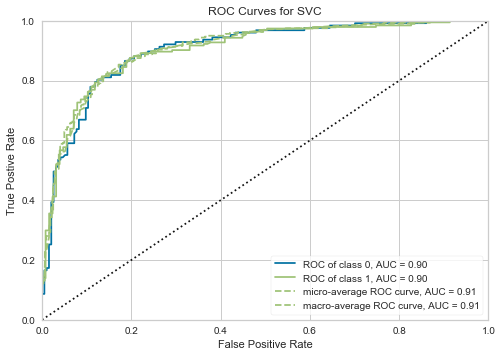

In [18]:
#check some cool plots
base_model(estimator='svm', plot='auc')

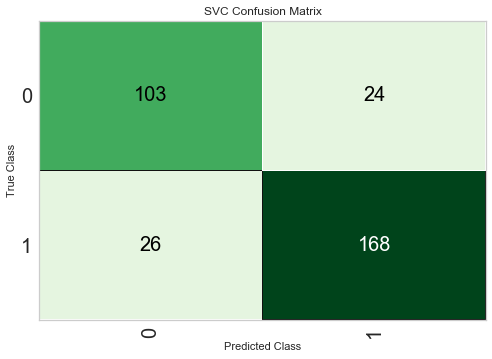

In [19]:
base_model(estimator='svm',plot='confusion_matrix')

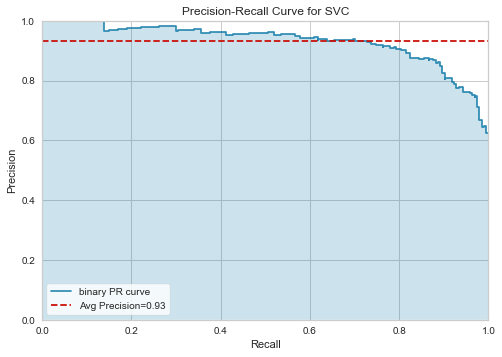

In [20]:
base_model(estimator='svm',plot='pr')

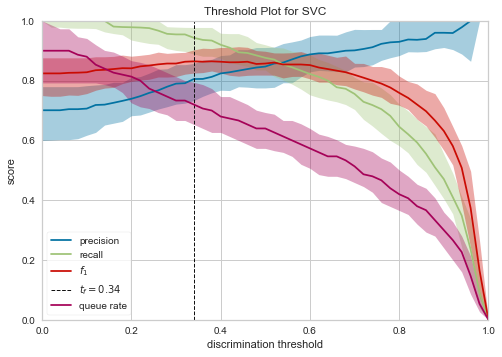

In [21]:
base_model(estimator='svm',plot='threshold')

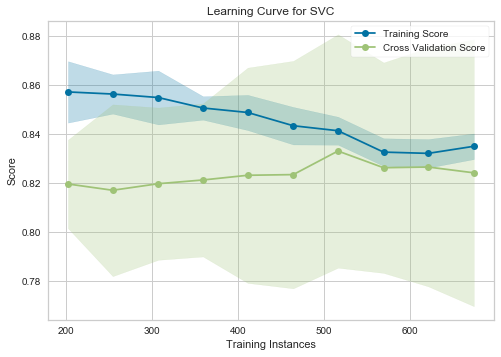

In [22]:
base_model(estimator='svm',plot='learning')

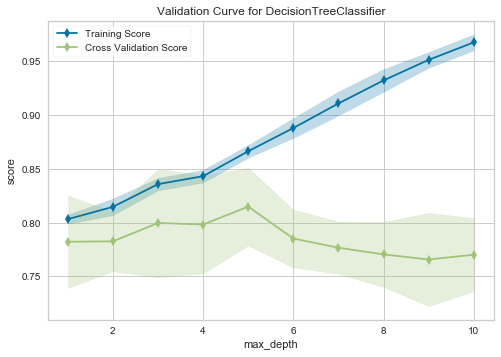

In [23]:
base_model(estimator='dt',plot='vc')

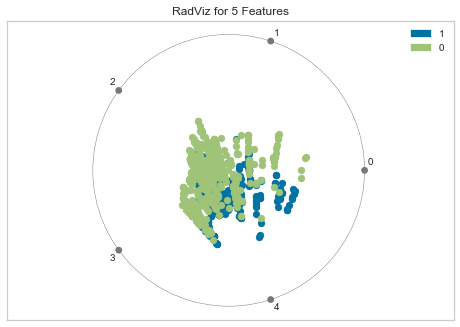

In [24]:
base_model(estimator='svm',plot='dimension') #known issue of Scaler. Code fix needed.

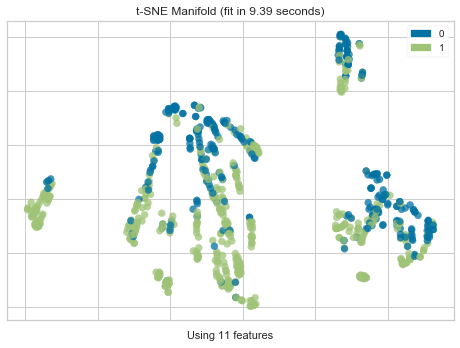

In [25]:
base_model(estimator='lr',plot='manifold')

C:\Users\mali085\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class DecisionBoundariesVisualizer is deprecated; Will be moved to yellowbrick.contrib in v0.8
  warnings.warn(msg, category=DeprecationWarning)


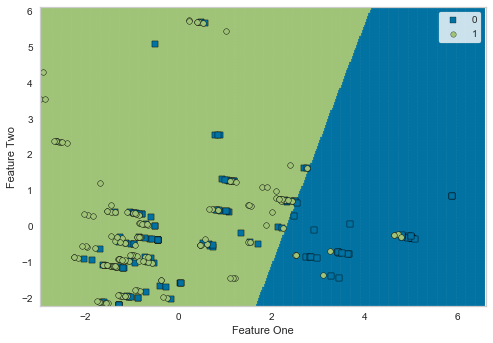

In [26]:
base_model(estimator='svm',plot='boundary') #deprecation warning to be turned off

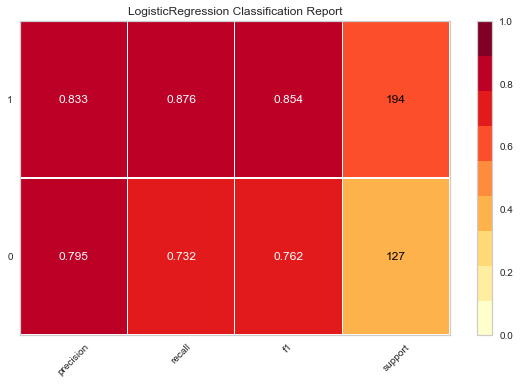

In [34]:
base_model(plot='class_report')

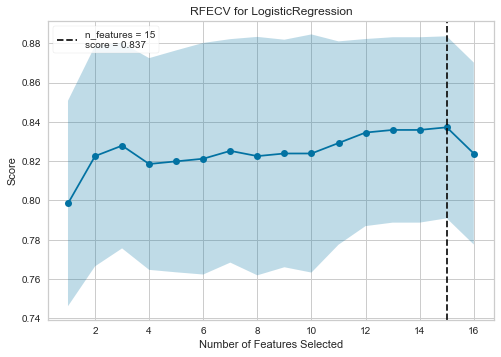

In [35]:
base_model(plot='rfe')

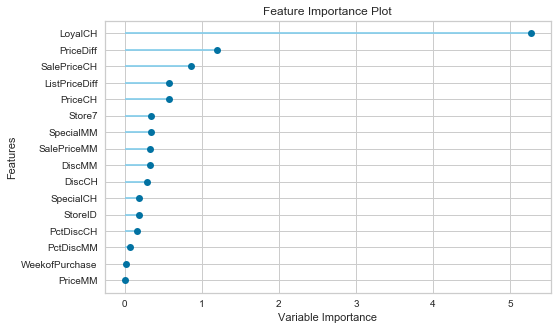

In [27]:
base_model(plot='feature')

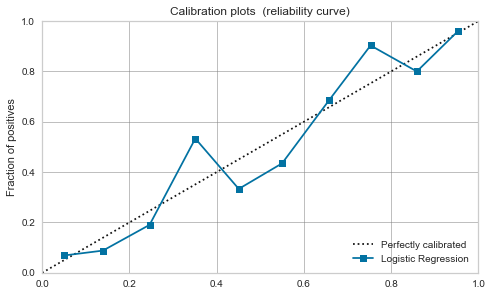

In [28]:
base_model(plot='calibration')

### compare_models()

In [29]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Support Vector Machine - Linear,0.8331,0.902,0.8758,0.9319,0.8635,0.6488
1,Logistic Regression,0.8278,0.9008,0.8781,0.9314,0.8599,0.6364
2,Neural Net - Multi Level Perceptron,0.773,0.8809,0.8624,0.9169,0.8188,0.512
3,Decision Tree,0.7664,0.7588,0.8028,0.7704,0.8049,0.5133
4,Gaussian Naive Bayes,0.7462,0.8228,0.736,0.8635,0.7769,0.4845
5,Gaussian Process Classifier,0.7451,0.789,0.8293,0.849,0.7964,0.4566
6,Support Vector Machine - RBF,0.7343,0.8125,0.8425,0.8678,0.7923,0.4263
7,K Nearest Neighbours,0.7037,0.772,0.7761,0.811,0.7594,0.3741


In [30]:
compare_models(ensemble=True, fold=5) #code needs fix to avoid warning

C:\Users\mali085\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mali085\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Support Vector Machine - Linear,0.8357,0.902,0.8781,0.9322,0.8656,0.6543
1,Logistic Regression,0.8304,0.9013,0.8803,0.9318,0.862,0.6419
2,Neural Net - Multi Level Perceptron,0.8184,0.8933,0.8825,0.9265,0.8543,0.6139
3,Decision Tree,0.7769,0.8559,0.8071,0.8757,0.8136,0.5355
4,Gaussian Naive Bayes,0.749,0.8271,0.7339,0.871,0.7788,0.4909
5,Support Vector Machine - RBF,0.745,0.8041,0.8824,0.8613,0.8063,0.4409
6,Gaussian Process Classifier,0.7356,0.7784,0.8336,0.8367,0.7915,0.4325
7,K Nearest Neighbours,0.7116,0.7788,0.7916,0.8351,0.7677,0.3883


In [31]:
# you can sort the module by defining any choice of metric by parameter sort = 'AUC' for example. 
# all the functionalities for base_model module will be available for compare_models
# you can also round the metrics to whatever decimal you prefer by simply passing round parameter. see example below:
compare_models(round=2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Logistic Regression,0.83,0.9,0.88,0.93,0.86,0.64
1,Support Vector Machine - Linear,0.83,0.9,0.88,0.93,0.86,0.65
2,Neural Net - Multi Level Perceptron,0.81,0.9,0.88,0.93,0.85,0.59
3,Decision Tree,0.76,0.76,0.8,0.77,0.8,0.51
4,Gaussian Naive Bayes,0.75,0.82,0.74,0.86,0.78,0.48
5,Gaussian Process Classifier,0.75,0.79,0.83,0.85,0.8,0.46
6,Support Vector Machine - RBF,0.73,0.81,0.84,0.87,0.79,0.43
7,K Nearest Neighbours,0.7,0.77,0.78,0.81,0.76,0.37


In [32]:
#blend all the models together combination = [7, of 8] This will be increased in future version.
blend_models()

,Model,Accuracy,AUC,Recall,Precision,F1,Kappa
0,LR + KNN + DT + SVM + SVM-RBF + GPC + MLP,0.8172,0.8904,0.8692,0.9208,0.8512,0.6142
1,LR + NB + DT + SVM + SVM-RBF + GPC + MLP,0.8131,0.8856,0.8537,0.9201,0.8462,0.6078
2,LR + KNN + NB + DT + SVM + GPC + MLP,0.8118,0.8887,0.8492,0.9202,0.8445,0.606
3,LR + KNN + NB + SVM + SVM-RBF + GPC + MLP,0.8078,0.8865,0.858,0.9188,0.8425,0.5955
4,LR + KNN + NB + DT + SVM + SVM-RBF + GPC,0.8077,0.8849,0.8514,0.9172,0.8419,0.5964
5,LR + KNN + NB + DT + SVM + SVM-RBF + MLP,0.8037,0.8846,0.8426,0.9185,0.8381,0.5888
6,LR + KNN + NB + DT + SVM-RBF + GPC + MLP,0.8024,0.8844,0.8403,0.9174,0.8364,0.5868
7,KNN + NB + DT + SVM + SVM-RBF + GPC + MLP,0.8024,0.8821,0.847,0.9146,0.8376,0.5853
